A1 — Entropy: 2.0012
A2 — Gini: 0.688
A3 — Best root feature: Fp2.__delta (IG = 0.007557)
A4 — Equal-width bins: 4
A4 — Equal-frequency bins: 4
A5 — ID3 training accuracy: 0.503
A6 — Fixed 2 features: ['Af3.__delta', 'Af4.__delta']


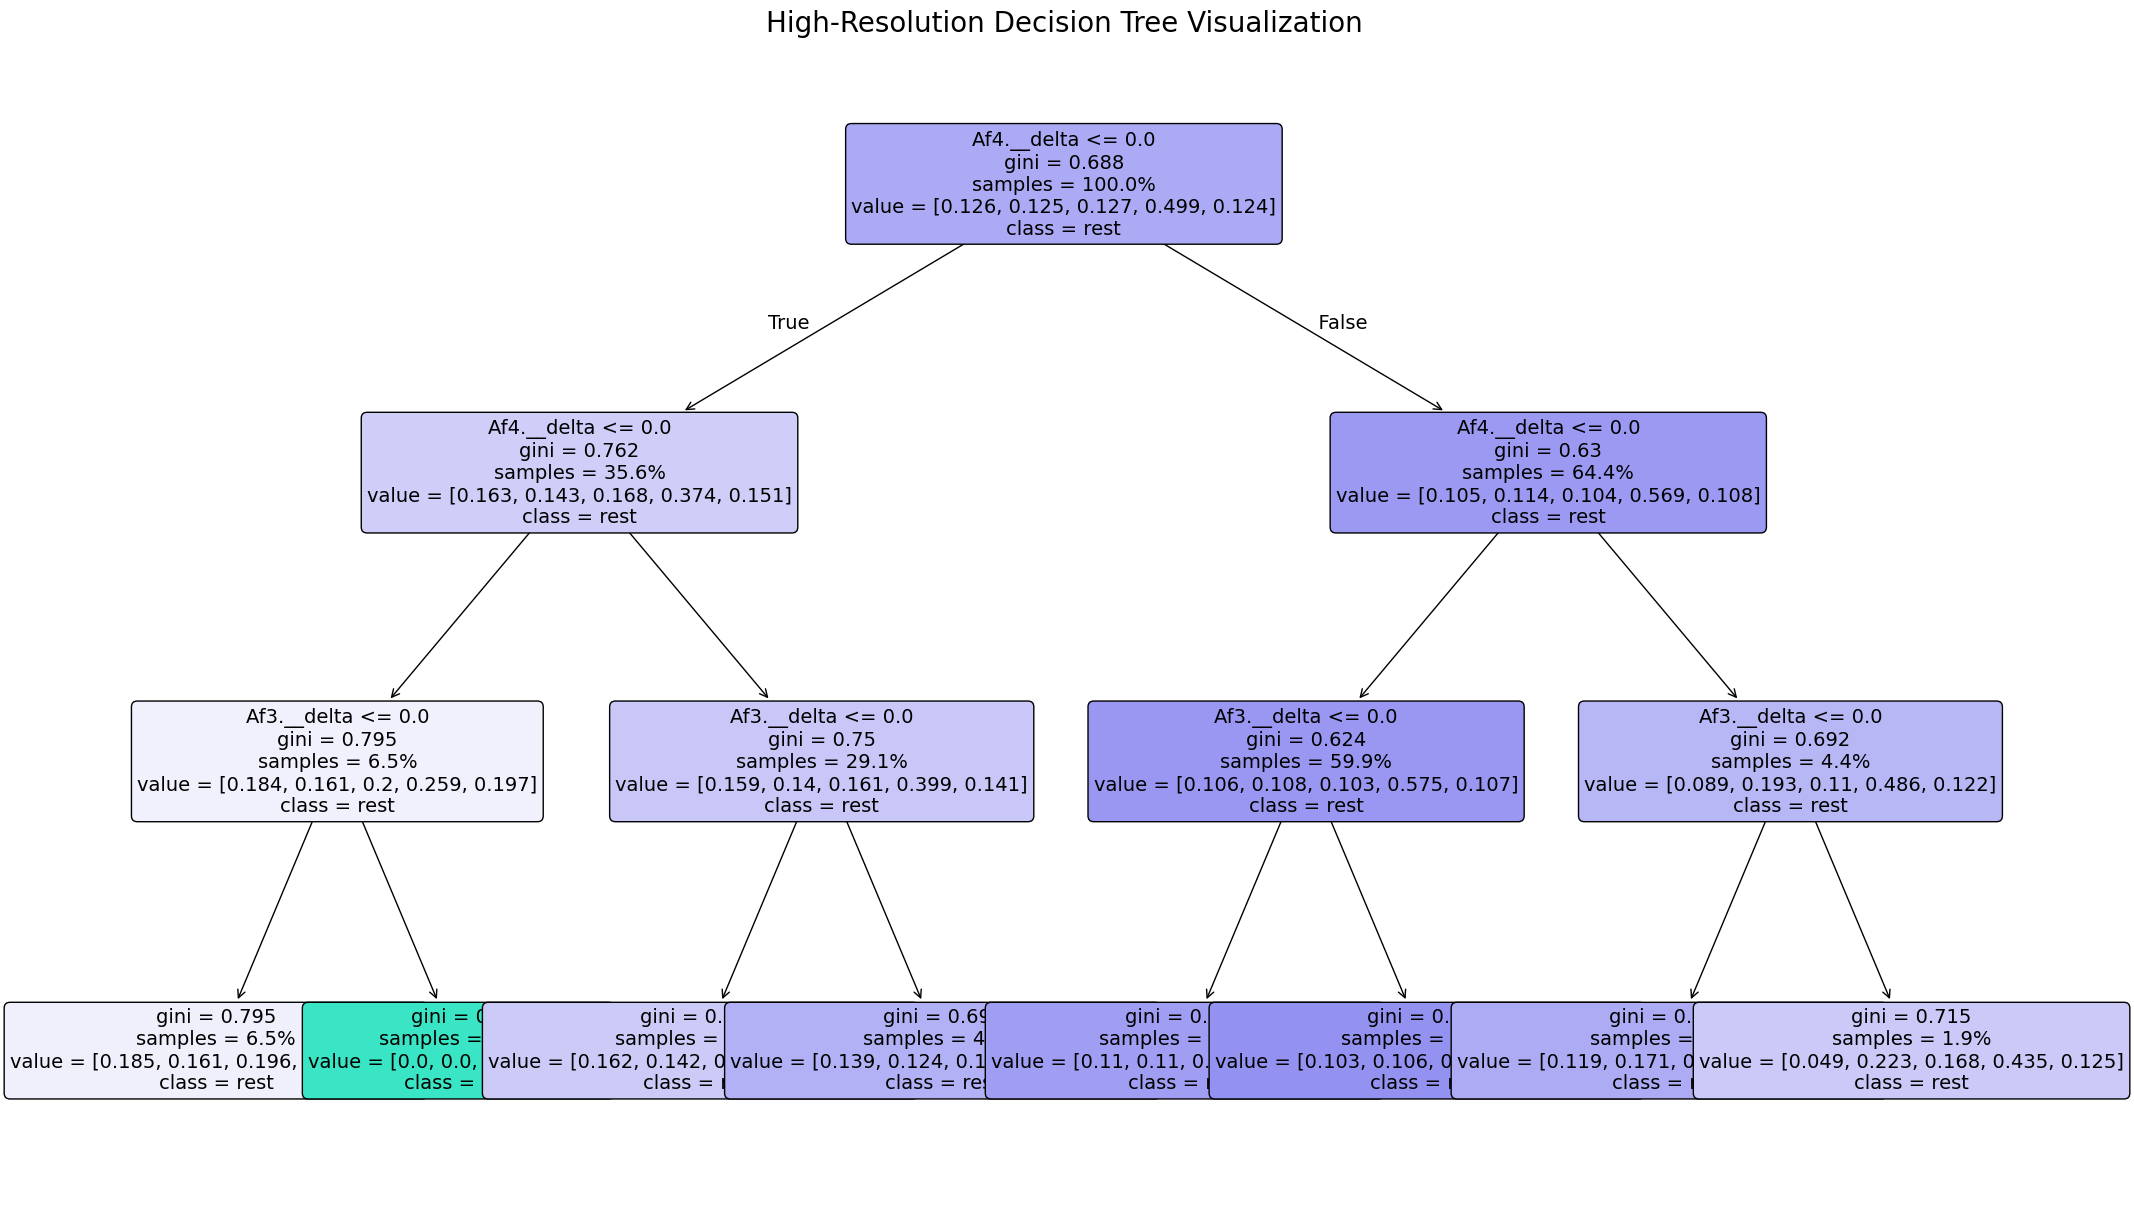

A7 — Decision boundary:


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


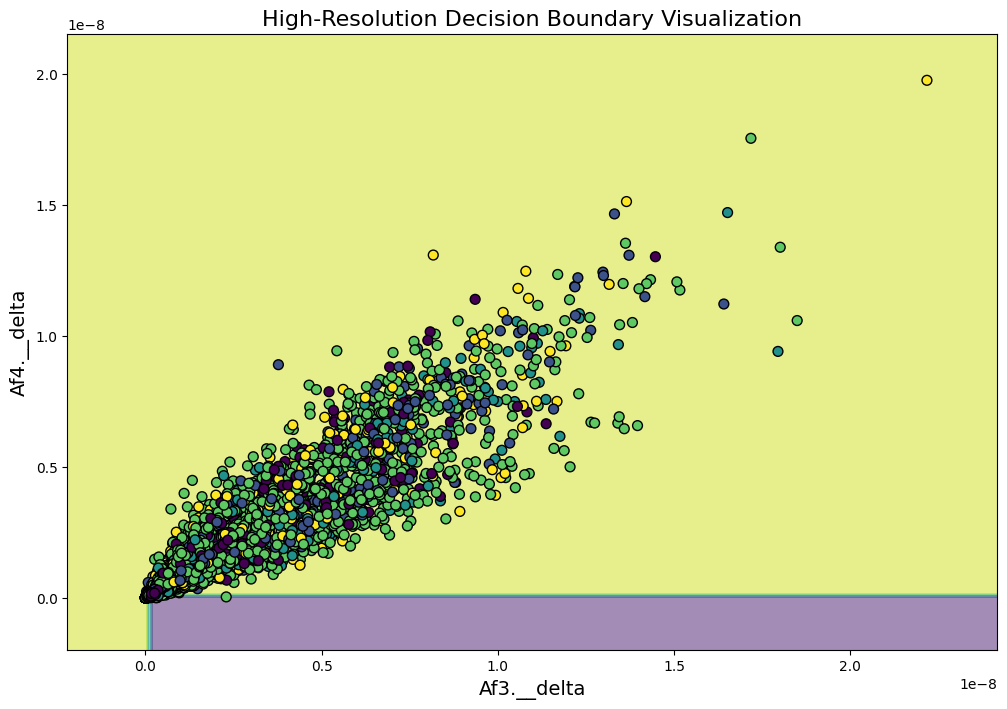

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# A4: Binning utilities — turn continuous variables into categories

def bin_equal_width(series: pd.Series, n_bins: int = 4) -> pd.Series:
    """
    Equal-width binning for continuous data.
    Splits the range of values into n_bins of equal size.
    """
    # converting input to numeric (any invalid entry like strings becomes NaN)
    s = pd.to_numeric(series, errors="coerce")
    # if series has only one unique value (or all values missing), assign all to bin 0
    if s.dropna().nunique() <= 1:
        return pd.Series(0, index=s.index)
    # pd.cut splits values into equal-width bins
    return pd.cut(
        s, bins=n_bins, labels=False, include_lowest=True, duplicates="drop"
    ).fillna(0).astype(int)  # missing values get bin 0

def bin_equal_frequency(series: pd.Series, n_bins: int = 4) -> pd.Series:
    """
    Equal-frequency binning (quantiles).
    Each bin gets ~same number of samples.
    """
    # convert input to numeric (non-numeric → NaN)
    s = pd.to_numeric(series, errors="coerce")
    # count unique values, if <=1 then binning makes no sense
    uniq = s.dropna().nunique()
    if uniq <= 1:
        return pd.Series(0, index=s.index)
    bins = min(n_bins, max(2, uniq))  # at least 2 bins, max = unique count
    try:
        return pd.qcut(
            s, q=bins, labels=False, duplicates="drop"
        ).fillna(0).astype(int)  # NaNs get bin 0
    except Exception:
        # fallback to equal-width if qcut fails
        return bin_equal_width(series, n_bins=bins)

def bin_series(series: pd.Series, n_bins: int = 4, method: str = "width") -> pd.Series:
    """Wrapper for choosing width or frequency binning."""
    if method == "frequency":
        return bin_equal_frequency(series, n_bins=n_bins)
    return bin_equal_width(series, n_bins=n_bins)

# A1 & A2: Measures of impurity — Entropy, Gini, Misclassification

def entropy(y: pd.Series) -> float:
    """Compute entropy of a categorical variable y."""
    values, counts = np.unique(y.dropna(), return_counts=True)
    if counts.size == 0:  # empty series
        return 0.0
    probs = counts / counts.sum()
    return float(-(probs * np.log2(probs)).sum())  # H = -sum(p log p)

def gini_index(y: pd.Series) -> float:
    """Compute Gini index of a categorical variable y."""
    values, counts = np.unique(y.dropna(), return_counts=True)
    if counts.size == 0:
        return 0.0
    probs = counts / counts.sum()
    return float(1.0 - (probs ** 2).sum())  # Gini = 1 - sum(p^2)

def misclassification_rate(y: pd.Series) -> float:
    """Misclassification = 1 - proportion of majority class."""
    values, counts = np.unique(y.dropna(), return_counts=True)
    if counts.size == 0:
        return 0.0
    return float(1.0 - counts.max() / counts.sum())

# A3: Information Gain & best root feature selection

def information_gain(target: pd.Series, feature_cat: pd.Series) -> float:
    """
    Compute Information Gain IG(target; feature).
    Assumes feature_cat is already categorical (binned).
    """
    base = entropy(target)
    weighted = 0.0
    for v, count in zip(*np.unique(feature_cat, return_counts=True)):
        subset = target[feature_cat == v]
        weighted += (count / len(target)) * entropy(subset)
    return float(base - weighted)

def best_root_feature(
    X_num: pd.DataFrame, y: pd.Series, n_bins: int = 4, binning_method: str = "width"
) -> Tuple[str, float, pd.Series]:
    """
    Find the numeric feature with highest information gain when binned.
    Returns (name, IG value, binned series).
    """
    best_name, best_gain, best_binned = None, -np.inf, None
    for col in X_num.columns:
        binned = bin_series(X_num[col], n_bins=n_bins, method=binning_method)
        gain = information_gain(y, binned)
        if gain > best_gain:
            best_name, best_gain, best_binned = col, gain, binned
    return best_name, best_gain, best_binned

# A5: Minimal ID3 decision tree implementation (educational)

@dataclass
class DTNode:
    feature: Optional[str] = None              # feature to split on
    children: Optional[Dict[int, "DTNode"]] = None  # bin_value → child
    prediction: Optional[int] = None           # predicted class if it's a leaf

def majority_class(y: pd.Series) -> int:
    """Return the most common class label in y."""
    vals, counts = np.unique(y, return_counts=True)
    return int(vals[np.argmax(counts)])

def id3_fit(X_binned: pd.DataFrame, y: pd.Series, depth: int = 0, max_depth: int = 3) -> DTNode:
    """
    Recursive ID3 on binned data.
    Stops when:
      - All labels are the same
      - No features left
      - Max depth reached
    """
    if y.nunique() == 1 or depth >= max_depth or X_binned.shape[1] == 0:
        return DTNode(prediction=majority_class(y))

    best_col, _, _ = best_root_feature(X_binned, y, n_bins=2, binning_method="width")
    if best_col is None:
        return DTNode(prediction=majority_class(y))

    node = DTNode(feature=best_col, children={})
    for bin_val in sorted(X_binned[best_col].unique()):
        mask = X_binned[best_col] == bin_val
        if mask.sum() == 0:
            node.children[int(bin_val)] = DTNode(prediction=majority_class(y))
        else:
            child_X = X_binned.loc[mask].drop(columns=[best_col])
            child_y = y.loc[mask]
            node.children[int(bin_val)] = id3_fit(child_X, child_y, depth + 1, max_depth)
    return node

def id3_predict_one(node: DTNode, row: pd.Series) -> int:
    """Traverse tree to predict label for one row."""
    while node and node.feature is not None:
        val = int(row[node.feature])
        if node.children is None or val not in node.children:
            break
        node = node.children[val]
    return node.prediction if node and node.prediction is not None else 0

def id3_predict(node: DTNode, X_binned: pd.DataFrame) -> np.ndarray:
    """Predict for multiple rows."""
    return np.array([id3_predict_one(node, X_binned.iloc[i]) for i in range(len(X_binned))])

# A6: Visualization helpers using sklearn

def train_sklearn_tree(X: pd.DataFrame, y: pd.Series, max_depth: int = 4) -> DecisionTreeClassifier:
    """Fit a sklearn DecisionTreeClassifier."""
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=0)
    clf.fit(X, y)
    return clf

# A7: Decision boundary for 2D feature space

def show_decision_boundary_2d(clf: DecisionTreeClassifier, X2: pd.DataFrame, y_enc: np.ndarray, feature_names: List[str]) -> None:
    """Plot 2D decision boundary for two features."""
    x_min, x_max = X2.iloc[:, 0].min(), X2.iloc[:, 0].max()
    y_min, y_max = X2.iloc[:, 1].min(), X2.iloc[:, 1].max()
    x_range, y_range = x_max - x_min, y_max - y_min

    xx, yy = np.meshgrid(
        np.arange(x_min - 0.1 * x_range, x_max + 0.1 * x_range, x_range/100),
        np.arange(y_min - 0.1 * y_range, y_max + 0.1 * y_range, y_range/100)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = clf.predict(grid).reshape(xx.shape)

    plt.figure(figsize=(12, 8))
    plt.contourf(xx, yy, zz, alpha=0.5, cmap=plt.cm.viridis)
    plt.scatter(X2.iloc[:, 0], X2.iloc[:, 1], c=y_enc, s=50, edgecolor="k", cmap=plt.cm.viridis)
    plt.xlabel(feature_names[0], fontsize=14)
    plt.ylabel(feature_names[1], fontsize=14)
    plt.title("High-Resolution Decision Boundary Visualization", fontsize=16)
    plt.savefig("decision_boundary_high_res.png", dpi=300)
    plt.show()

# Data preparation utility

def split_features_target(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    """Separate numeric feature columns from the label column."""
    non_features = {"file", "run", "label", "onset_s"}
    numeric_cols = [c for c in df.columns if c not in non_features]
    X = df[numeric_cols].apply(pd.to_numeric, errors="coerce")
    y = df["label"].astype(str)
    mask = y.notna()
    return X.loc[mask], y.loc[mask]

# Main script

if __name__ == "__main__":
    # Loading the dataset
    csv_path = "/content/features_filtered.csv"
    df = pd.read_csv(csv_path)

    # Split into numeric features and labels
    X_num, y_str = split_features_target(df)

    # Encode labels as integers for sklearn
    le = LabelEncoder()
    y_enc = le.fit_transform(y_str)
    class_names = list(le.classes_)

    # A1 & A2: Entropy & Gini
    target_entropy = entropy(y_str)
    target_gini = gini_index(y_str)
    print("A1 — Entropy:", round(target_entropy, 4))
    print("A2 — Gini:", round(target_gini, 4))

    # A3: Best root feature by IG
    root_name, root_gain, _ = best_root_feature(X_num, y_str, n_bins=4, binning_method="width")
    print(f"A3 — Best root feature: {root_name} (IG = {root_gain:.6f})")

    # A4: Show binning results for root feature
    root_binned_width = bin_series(X_num[root_name], 4, "width")
    root_binned_freq = bin_series(X_num[root_name], 4, "frequency")
    print("A4 — Equal-width bins:", int(root_binned_width.max() + 1))
    print("A4 — Equal-frequency bins:", int(root_binned_freq.max() + 1))

    # A5: Train tiny ID3 tree on all binned features
    X_binned = X_num.apply(lambda s: bin_series(s, 4, "width"))
    tiny_tree = id3_fit(X_binned, pd.Series(y_enc, index=X_binned.index), max_depth=3)
    preds_id3 = id3_predict(tiny_tree, X_binned)
    acc_id3 = (preds_id3 == y_enc).mean()
    print(f"A5 — ID3 training accuracy: {acc_id3:.3f}")

    # A6: Train sklearn tree on Af3.__delta and Af4.__delta
    top2 = ["Af3.__delta", "Af4.__delta"]
    X2 = X_num[top2].fillna(X_num[top2].median())  # handle missing values
    clf2 = train_sklearn_tree(X2, y_enc, max_depth=3)
    print("A6 — Fixed 2 features:", top2)

    # Show decision tree (high resolution)
    plt.figure(figsize=(25, 15))
    plot_tree(
        clf2,
        feature_names=top2,
        class_names=class_names,
        filled=True,
        rounded=True,
        fontsize=14,
        proportion=True
    )
    plt.title("High-Resolution Decision Tree Visualization", fontsize=20)
    plt.savefig("decision_tree_high_res.png", dpi=300)
    plt.show()

    # A7: Plot decision boundary for those 2 features
    print("A7 — Decision boundary:")
    show_decision_boundary_2d(clf2, X2, y_enc, top2)
